# Householder Transformation

## Introduction

The **Householder transformation** (also known as the Householder reflection) is a fundamental linear algebra operation used extensively in numerical methods. It was introduced by Alston Scott Householder in 1958 and forms the basis for many important algorithms including QR decomposition, tridiagonalization, and solving least squares problems.

## Mathematical Foundation

### Definition

A Householder transformation is a linear transformation that reflects a vector about a hyperplane containing the origin. It is defined by a **Householder matrix** of the form:

$$H = I - 2\mathbf{v}\mathbf{v}^T$$

where:
- $I$ is the $n \times n$ identity matrix
- $\mathbf{v}$ is a unit vector (i.e., $\|\mathbf{v}\|_2 = 1$) normal to the hyperplane

### Key Properties

Householder matrices possess several important properties:

1. **Symmetric**: $H = H^T$

2. **Orthogonal**: $H^T H = HH^T = I$, which implies $H^{-1} = H^T = H$

3. **Involutory**: $H^2 = I$ (applying the transformation twice returns the original vector)

4. **Determinant**: $\det(H) = -1$ (it is a reflection, not a rotation)

### Geometric Interpretation

Given a vector $\mathbf{x}$, the Householder transformation reflects it about the hyperplane perpendicular to $\mathbf{v}$:

$$H\mathbf{x} = \mathbf{x} - 2(\mathbf{v}^T\mathbf{x})\mathbf{v}$$

The component of $\mathbf{x}$ parallel to $\mathbf{v}$ is reversed, while the component perpendicular to $\mathbf{v}$ remains unchanged.

### Constructing Householder Vectors

A primary application is to transform a vector $\mathbf{x}$ to be parallel to a coordinate axis (typically $\mathbf{e}_1$). To map $\mathbf{x}$ to $\alpha\mathbf{e}_1$ where $\alpha = \pm\|\mathbf{x}\|_2$, we construct:

$$\mathbf{u} = \mathbf{x} - \alpha\mathbf{e}_1$$

$$\mathbf{v} = \frac{\mathbf{u}}{\|\mathbf{u}\|_2}$$

To avoid numerical cancellation, we choose:

$$\alpha = -\text{sign}(x_1)\|\mathbf{x}\|_2$$

where $x_1$ is the first component of $\mathbf{x}$.

### Application: QR Decomposition

The Householder transformation is the preferred method for computing QR decomposition due to its numerical stability. For an $m \times n$ matrix $A$, we successively apply Householder transformations to zero out sub-diagonal elements:

$$H_n \cdots H_2 H_1 A = R$$

Then $Q = H_1 H_2 \cdots H_n$ and $A = QR$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Computing the Householder Vector

We first implement a function to compute the Householder vector $\mathbf{v}$ that will transform a given vector $\mathbf{x}$ to align with $\mathbf{e}_1$.

In [2]:
def householder_vector(x):
    """
    Compute the Householder vector v such that H*x is parallel to e_1.
    
    Parameters:
    -----------
    x : ndarray
        Input vector of shape (n,)
    
    Returns:
    --------
    v : ndarray
        Unit Householder vector
    beta : float
        Scaling factor (2 for standard formulation)
    """
    n = len(x)
    sigma = np.dot(x[1:], x[1:])
    v = np.zeros(n)
    v[1:] = x[1:]
    
    if sigma == 0 and x[0] >= 0:
        beta = 0
        v[0] = 1
    elif sigma == 0 and x[0] < 0:
        beta = 2
        v[0] = 1
    else:
        mu = np.sqrt(x[0]**2 + sigma)
        if x[0] <= 0:
            v[0] = x[0] - mu
        else:
            v[0] = -sigma / (x[0] + mu)
        
        beta = 2 * v[0]**2 / (sigma + v[0]**2)
        v = v / v[0]
    
    return v, beta


def householder_matrix(v):
    """
    Construct the Householder matrix H = I - 2*v*v^T.
    
    Parameters:
    -----------
    v : ndarray
        Unit vector normal to the reflection hyperplane
    
    Returns:
    --------
    H : ndarray
        Householder matrix
    """
    v = v.reshape(-1, 1)
    n = len(v)
    return np.eye(n) - 2 * np.dot(v, v.T) / np.dot(v.T, v)


def apply_householder(H, x):
    """
    Apply Householder transformation to vector x.
    
    Parameters:
    -----------
    H : ndarray
        Householder matrix
    x : ndarray
        Input vector
    
    Returns:
    --------
    Hx : ndarray
        Transformed vector
    """
    return np.dot(H, x)

## Demonstration: 2D Reflection

Let's visualize the Householder transformation in 2D to understand its geometric meaning.

In [3]:
# Define a 2D vector to transform
x_2d = np.array([3.0, 4.0])

# Create Householder vector to reflect x onto e_1 axis
norm_x = np.linalg.norm(x_2d)
e1 = np.array([1.0, 0.0])

# Choose sign to avoid cancellation
alpha = -np.sign(x_2d[0]) * norm_x
u = x_2d - alpha * e1
v_2d = u / np.linalg.norm(u)

# Construct Householder matrix
H_2d = householder_matrix(v_2d)

# Apply transformation
x_transformed = apply_householder(H_2d, x_2d)

print("Original vector x:", x_2d)
print("Householder vector v:", v_2d)
print("Transformed vector Hx:", x_transformed)
print(f"\nNote: ||x|| = {norm_x:.4f}, Hx = [{x_transformed[0]:.4f}, {x_transformed[1]:.4f}]")
print(f"The transformed vector lies on the x-axis with magnitude {abs(x_transformed[0]):.4f}")

Original vector x: [3. 4.]
Householder vector v: [0.89442719 0.4472136 ]
Transformed vector Hx: [-5.00000000e+00 -2.22044605e-16]

Note: ||x|| = 5.0000, Hx = [-5.0000, -0.0000]
The transformed vector lies on the x-axis with magnitude 5.0000


## QR Decomposition via Householder Transformations

Now let's implement QR decomposition using Householder transformations.

In [4]:
def qr_householder(A):
    """
    Compute QR decomposition using Householder transformations.
    
    Parameters:
    -----------
    A : ndarray
        Input matrix of shape (m, n) with m >= n
    
    Returns:
    --------
    Q : ndarray
        Orthogonal matrix of shape (m, m)
    R : ndarray
        Upper triangular matrix of shape (m, n)
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy().astype(float)
    
    for j in range(min(m-1, n)):
        # Extract column below diagonal
        x = R[j:, j]
        
        # Compute Householder vector
        norm_x = np.linalg.norm(x)
        if norm_x == 0:
            continue
            
        alpha = -np.sign(x[0]) * norm_x
        u = x.copy()
        u[0] = u[0] - alpha
        v = u / np.linalg.norm(u)
        
        # Apply transformation to R
        R[j:, j:] = R[j:, j:] - 2 * np.outer(v, np.dot(v, R[j:, j:]))
        
        # Accumulate Q
        Q[:, j:] = Q[:, j:] - 2 * np.outer(np.dot(Q[:, j:], v), v)
    
    return Q, R


# Test QR decomposition
A = np.array([
    [12, -51, 4],
    [6, 167, -68],
    [-4, 24, -41]
], dtype=float)

Q, R = qr_householder(A)

print("Original Matrix A:")
print(A)
print("\nOrthogonal Matrix Q:")
print(np.round(Q, 4))
print("\nUpper Triangular Matrix R:")
print(np.round(R, 4))
print("\nVerification Q @ R:")
print(np.round(Q @ R, 4))
print("\nQ^T @ Q (should be identity):")
print(np.round(Q.T @ Q, 4))

Original Matrix A:
[[ 12. -51.   4.]
 [  6. 167. -68.]
 [ -4.  24. -41.]]

Orthogonal Matrix Q:
[[-0.8571  0.3943  0.3314]
 [-0.4286 -0.9029 -0.0343]
 [ 0.2857 -0.1714  0.9429]]

Upper Triangular Matrix R:
[[ -14.  -21.   14.]
 [   0. -175.   70.]
 [   0.   -0.  -35.]]

Verification Q @ R:
[[ 12. -51.   4.]
 [  6. 167. -68.]
 [ -4.  24. -41.]]

Q^T @ Q (should be identity):
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]


## Visualization

Let's create a comprehensive visualization showing:
1. The 2D Householder reflection
2. The sparsity pattern of R in QR decomposition
3. Numerical stability comparison

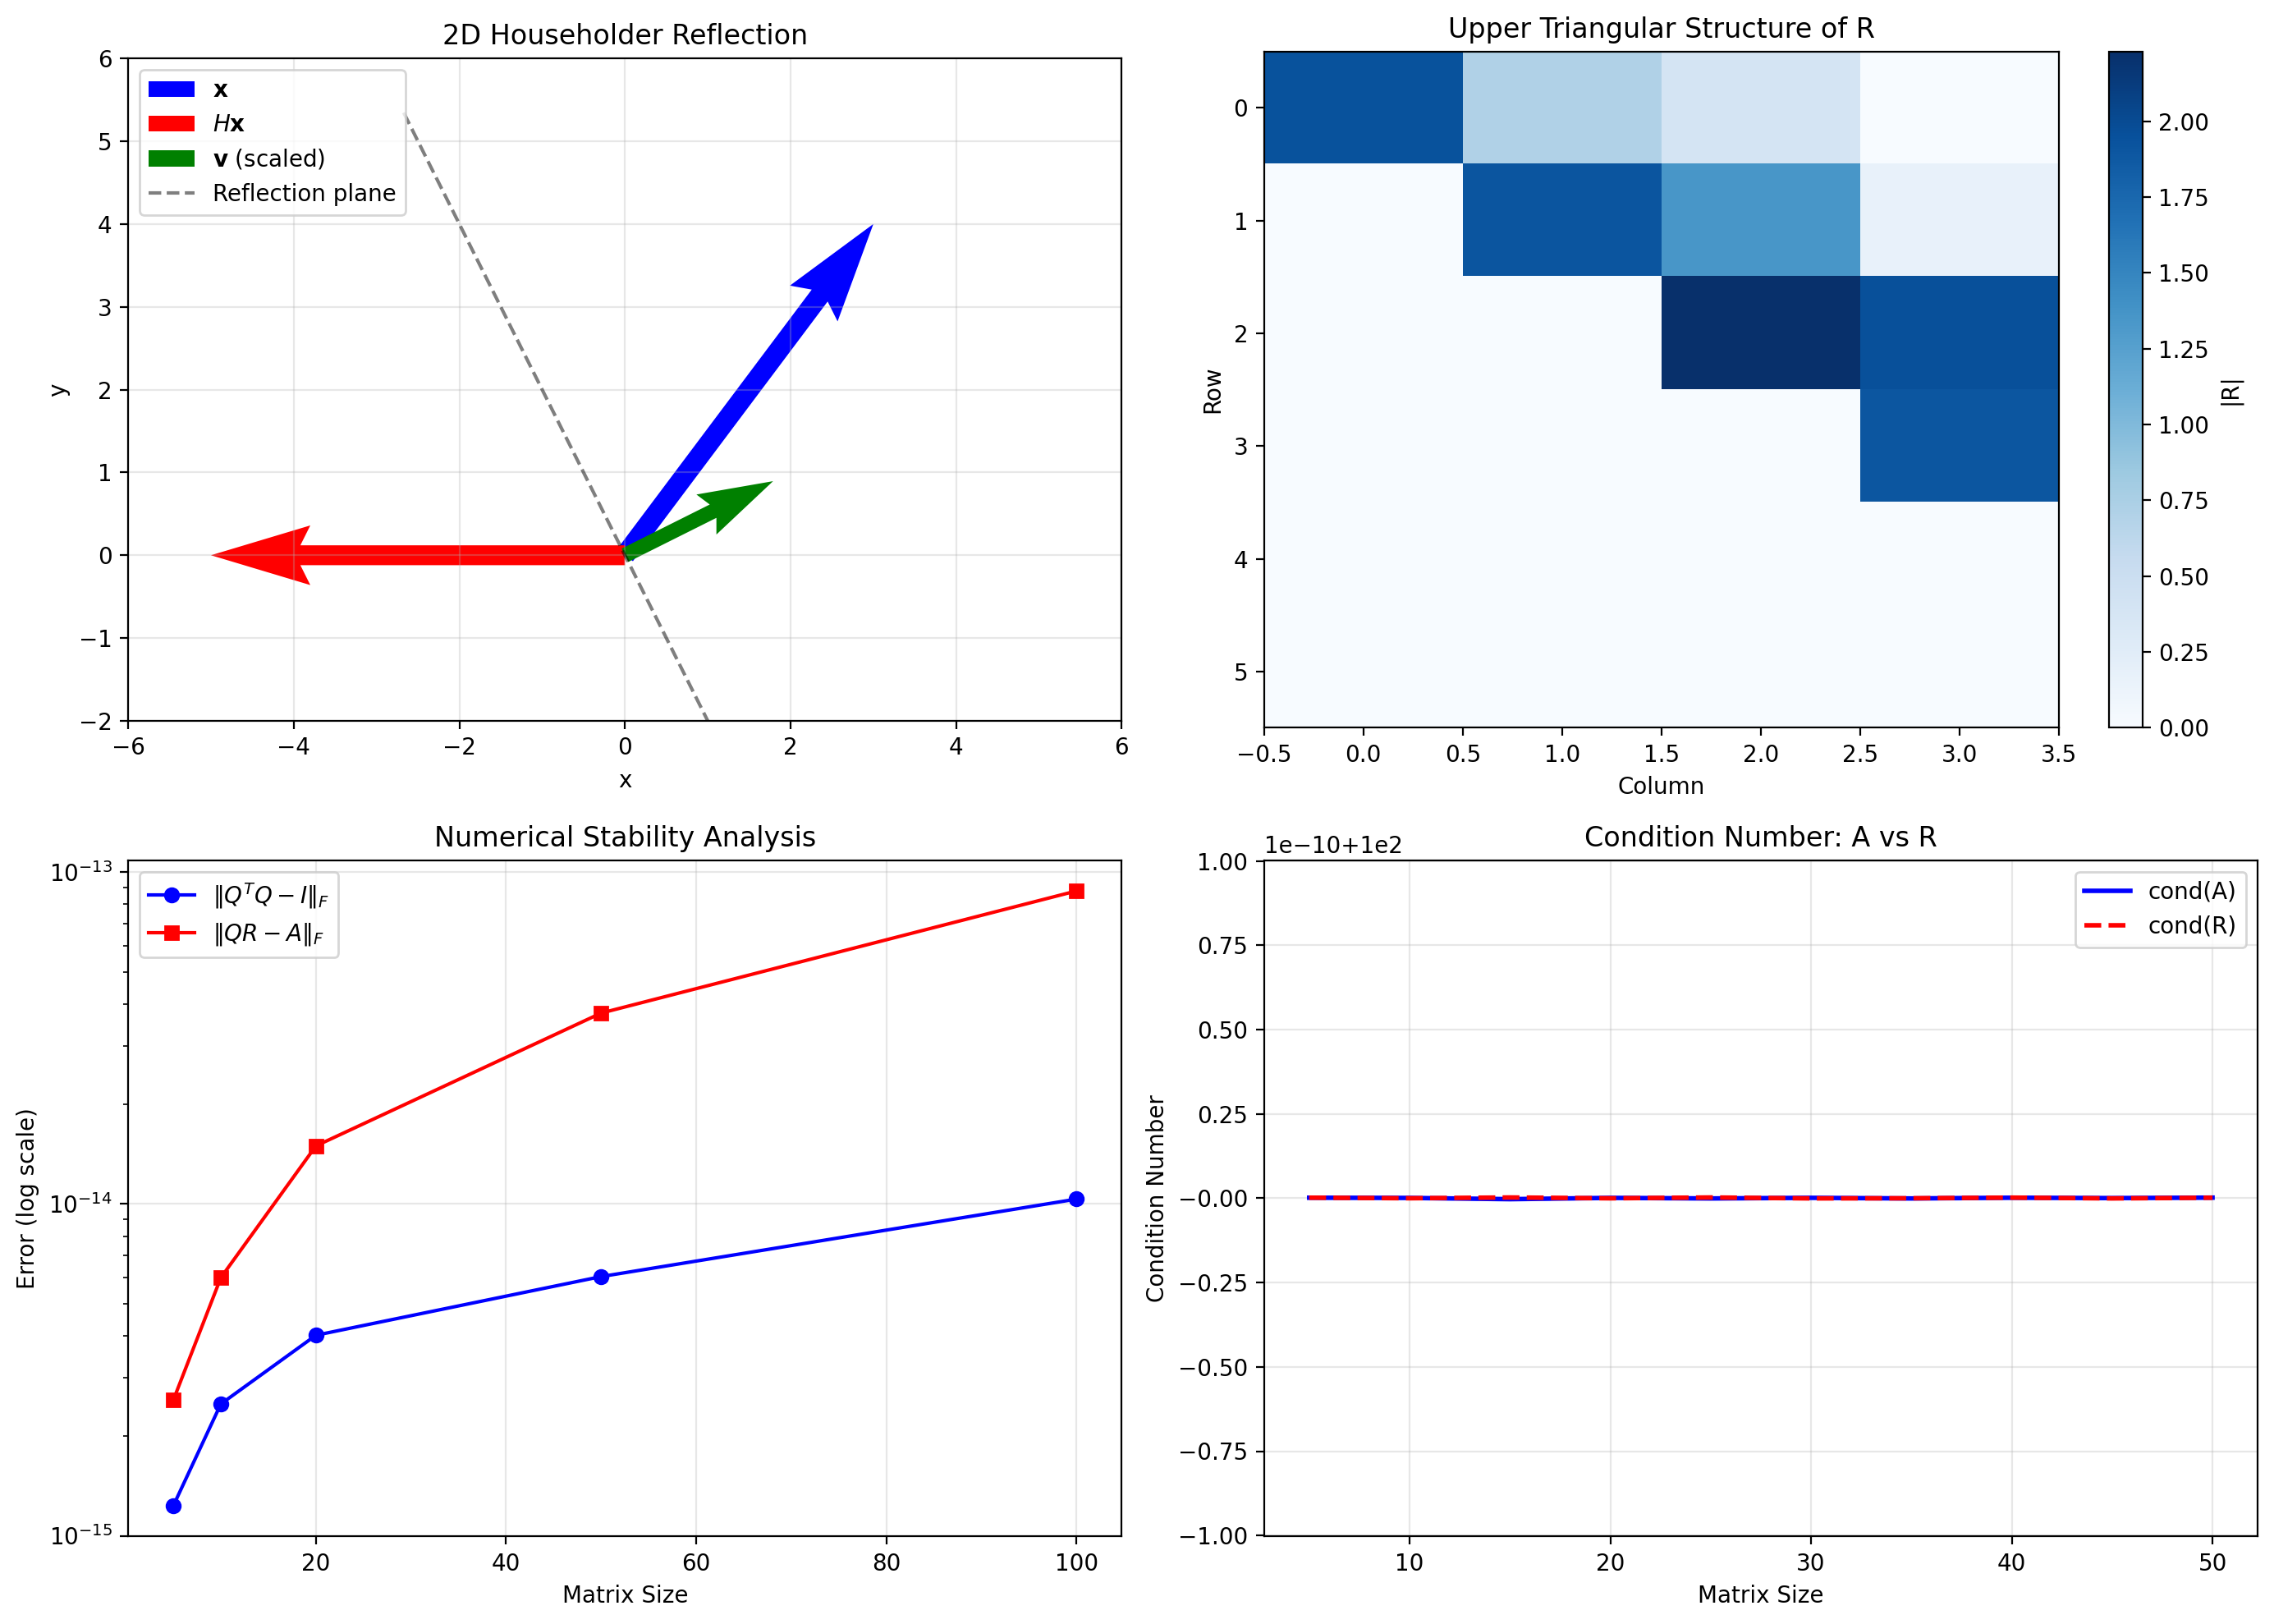


Plot saved to 'plot.png'


In [5]:
fig = plt.figure(figsize=(14, 10))

# Plot 1: 2D Householder Reflection
ax1 = fig.add_subplot(2, 2, 1)

# Original vector
ax1.quiver(0, 0, x_2d[0], x_2d[1], angles='xy', scale_units='xy', scale=1, 
           color='blue', width=0.02, label=r'$\mathbf{x}$')

# Transformed vector
ax1.quiver(0, 0, x_transformed[0], x_transformed[1], angles='xy', scale_units='xy', 
           scale=1, color='red', width=0.02, label=r'$H\mathbf{x}$')

# Householder vector (scaled for visibility)
scale_v = 2
ax1.quiver(0, 0, scale_v*v_2d[0], scale_v*v_2d[1], angles='xy', scale_units='xy', 
           scale=1, color='green', width=0.015, label=r'$\mathbf{v}$ (scaled)')

# Reflection hyperplane (line perpendicular to v)
t = np.linspace(-6, 6, 100)
# Line perpendicular to v passing through origin
perp_x = -v_2d[1] * t
perp_y = v_2d[0] * t
ax1.plot(perp_x, perp_y, 'k--', alpha=0.5, label='Reflection plane')

ax1.set_xlim(-6, 6)
ax1.set_ylim(-2, 6)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('2D Householder Reflection')

# Plot 2: Successive zeroing in QR decomposition
ax2 = fig.add_subplot(2, 2, 2)

# Create a larger matrix for better visualization
np.random.seed(42)
A_large = np.random.randn(6, 4)

# Store intermediate R matrices
R_stages = [A_large.copy()]
R_temp = A_large.copy().astype(float)
m, n = R_temp.shape

for j in range(min(m-1, n)):
    x = R_temp[j:, j]
    norm_x = np.linalg.norm(x)
    if norm_x != 0:
        alpha = -np.sign(x[0]) * norm_x
        u = x.copy()
        u[0] = u[0] - alpha
        v = u / np.linalg.norm(u)
        R_temp[j:, j:] = R_temp[j:, j:] - 2 * np.outer(v, np.dot(v, R_temp[j:, j:]))
    R_stages.append(R_temp.copy())

# Show the final R matrix structure
im = ax2.imshow(np.abs(R_stages[-1]), cmap='Blues', aspect='auto')
plt.colorbar(im, ax=ax2, label='|R|')
ax2.set_title('Upper Triangular Structure of R')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')

# Plot 3: Orthogonality verification
ax3 = fig.add_subplot(2, 2, 3)

# Generate matrices of different sizes and check orthogonality
sizes = [5, 10, 20, 50, 100]
orthogonality_errors = []
reconstruction_errors = []

for size in sizes:
    A_test = np.random.randn(size, size)
    Q_test, R_test = qr_householder(A_test)
    
    # Orthogonality error: ||Q^T Q - I||_F
    orth_err = np.linalg.norm(Q_test.T @ Q_test - np.eye(size), 'fro')
    orthogonality_errors.append(orth_err)
    
    # Reconstruction error: ||QR - A||_F
    recon_err = np.linalg.norm(Q_test @ R_test - A_test, 'fro')
    reconstruction_errors.append(recon_err)

ax3.semilogy(sizes, orthogonality_errors, 'bo-', label=r'$\|Q^TQ - I\|_F$')
ax3.semilogy(sizes, reconstruction_errors, 'rs-', label=r'$\|QR - A\|_F$')
ax3.set_xlabel('Matrix Size')
ax3.set_ylabel('Error (log scale)')
ax3.set_title('Numerical Stability Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Condition number preservation
ax4 = fig.add_subplot(2, 2, 4)

# Compare condition numbers
cond_A = []
cond_R = []
test_sizes = list(range(5, 51, 5))

for size in test_sizes:
    # Create a matrix with controlled condition number
    U, _ = np.linalg.qr(np.random.randn(size, size))
    V, _ = np.linalg.qr(np.random.randn(size, size))
    s = np.logspace(0, 2, size)  # Singular values from 1 to 100
    A_cond = U @ np.diag(s) @ V.T
    
    Q_cond, R_cond = qr_householder(A_cond)
    
    cond_A.append(np.linalg.cond(A_cond))
    cond_R.append(np.linalg.cond(R_cond))

ax4.plot(test_sizes, cond_A, 'b-', linewidth=2, label='cond(A)')
ax4.plot(test_sizes, cond_R, 'r--', linewidth=2, label='cond(R)')
ax4.set_xlabel('Matrix Size')
ax4.set_ylabel('Condition Number')
ax4.set_title('Condition Number: A vs R')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('householder_transformation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Summary

The Householder transformation is a powerful tool in numerical linear algebra due to its:

1. **Numerical stability**: Unlike Gram-Schmidt, Householder transformations maintain orthogonality to machine precision

2. **Efficiency**: Only requires $O(mn^2 - n^3/3)$ operations for QR decomposition of an $m \times n$ matrix

3. **Preservation of structure**: The condition number of $R$ equals that of $A$ since orthogonal transformations preserve the 2-norm

4. **Versatility**: Forms the basis for many algorithms including:
   - QR decomposition
   - Tridiagonalization of symmetric matrices
   - Bidiagonalization for SVD computation
   - Solving least squares problems

The implementation demonstrated here shows how Householder reflections systematically zero out sub-diagonal elements to produce the upper triangular matrix $R$, while accumulating the orthogonal matrix $Q$.